# Run ML Insights using APIs

# Use Case

This Notebook shows how to use ML Insights declarative API to define and customise all of its core features like data scheme, data ingestion, data transformation, metric calculation and post processing of metric output .

## Note

### Performance metrics for classification models

- Metrics 
    - AccuracyScore , PrecisionScore , RecallScore , FBetaScore , FalsePositiveRate , FalseNegativeRate, Specificity , ConfusionMatrix , LogLoss , ROCCurve , ROCAreaUnderCurve , PrecisionRecallCurve , PrecisionRecallAreaUnderCurve 
- Performance Metrics For classsification Models works only for categorical type input features
- Confusion Matrix will work for following 
    - Binary class
    - Multi-class
    - Support only upto 256 labels
- Aggregate metrics 
    - Accuracy
    - Precision (Micro, Macro, Weighted)
    - Recall (Micro, Macro, Weighted)
    - F-beta score (Micro, Macro, Weighted) 
    - beta = 1
    - False Positive Rate works only for binary classification
    - False Negative Rate works only for binary classification
    - Specificity works only for binary classification
    - Log Loss require a feature in dataset which has Column Type as Prediction score
- Curves (Only for binary classification)
    - ROC Curve works only for binary classification
    - ROC- AUC works only for binary classification
    - Precision-Recall curve works only for binary classification
    - Precision-Recall curve / AUC works only for binary classification
- Performance metrics for classsification models needs to have target and prediction features in feature schema. This includes:
    - Column Type as Target for ground truth column , If these columns are missing or not configured, Insights throw validation errors
    - Column Type as Prediction for prediction column , If these columns are missing or not configured, Insights throw validation errors
    - Prediction score option in Column Type 
- All performance metrics for classsification models can be view using following Profile API:
    - to_json
    
### Performance Metrics For Regression Models

- Metrics
    - MeanAbsoluteError , MeanSquaredError , R2Score , RootMeanSquaredError , MeanSquaredLogError , MeanAbsolutePercentageError ,  MaxError 
- Performance Metrics For Regression Models works only for contineous type input features
- Performance Metrics For Regression Models needs to have target and prediction features in feature schema. This includes:
    - Column Type as Target for ground truth column ,If these columns are missing or not configured, Insights throw validation errors
    - Column Type as Prediction for prediction column ,If these columns are missing or not configured, Insights throw validation errors
    
### Conflict metrics
- Metrics
    - ConflictPrediction , ConflictLabel
- Conflict metrics are approximate metric.
- Conflict metrics needs to have target and prediction features in feature schema. This includes:
    - Column Type as Target for ground truth column ,If these columns are missing or not configured, Insights throw validation errors
    - Column Type as Prediction for prediction column ,If these columns are missing or not configured, Insights throw validation errors
    
### Drift metrics

- Metrics 
    - Kolmogorov Smirnov , Chi square Goodness of Fit Test , Kullback Leibler Divergence ,Jensen Shannon (JS) , Population Stability Index (PSI)
- Supported Drift metric algorithm for Numerical feature which needs to define variable_type=VariableType.CONTINUOUS :
    - Kolmogorov Smirnov
    - Kullback Leibler Divergence
    - Jensen Shannon (JS)
    - Population Stability Index (PSI)
- Supported Drift metric algorithm for Categorical feature which needs to define variable_type=VariableType.NOMINAL :
    - Chi square Goodness of Fit Test
- To view the drift metrics user needs to pass a reference profile to Profile API method ie to_json() , to_pandas() .
    - Eg. result =  base_profile.to_json(reference_profile=reference_profile_data)
    
### Data Quality & Data Integrity Metrics
- Metrics
    - Sum ,TypeMetric , Mean , Min , StandardDeviation , Variance , Max , Range , Count , Skewness , Kurtosis , Quartiles , IQR , TopKFrequentElements , FrequencyDistribution , DistinctCount , DuplicateCount , Mode , IsConstantFeature , IsQuasiConstantFeature , ProbabilityDistribution    
- All Data Quality & Data Integrity Metrics needs to define VariableType and DataType of feature in feature schema. This includes:
    - variable_type=VariableType.CONTINUOUS for Numerical features
    - variable_type=VariableType.NOMINAL for Categorical features
    - Supported datatype : data_type=DataType.FLOAT , data_type=DataType.INTEGER ,data_type=DataType.STRING , data_type=DataType.TEXT ,data_type=DataType.BOOLEAN
    
## About Dataset
The data was collected and made available by “National Institute of Diabetes and Digestive and Kidney Diseases” as part of the Pima Indians Diabetes Database. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here belong to the Pima Indian heritage (subgroup of Native Americans), and are females of ages 21 and above.

The data set contains medical and demographic data of patients . It consists of various features such as Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, Outcome, Prediction, BMICategory, Prediction_Score .

Dataset source : https://www.kaggle.com/datasets/kandij/diabetes-dataset


# Install ML Observability Insights Library SDK

- Prerequisites
    - Linux/Mac (Intel CPU)
    - Python 3.8 and 3.9 only


- Installation
    - ML Insights is made available as a Python package (via Artifactory) which can be installed using pip install as shown below. Depending on the execution engine on which to do the run, one can use scoped package. For eg: if we want to run on dask, use oracle-ml-insights[dask], for spark use oracle-ml-insights[spark], for native use oracle-ml-insights. One can install all the dependencies as use oracle-ml-insights[all]

      !pip install oracle-ml-insights

Refer : [Installation and Setup](https://docs.oracle.com/en-us/iaas/tools/ml-insights-docs/latest/ml-insights-documentation/html/user_guide/tutorials/install.html)

In [ ]:
!python3 -m pip install oracle-ml-insights

In [ ]:
!python3 -m pip install matplotlib

# 1 ML Insights Imports 

In [14]:
# imports

import os
from typing import Any
import pyarrow as pa
import pandas as pd
import json

# Import Data Quality metrics 
from mlm_insights.core.metrics.count import Count
from mlm_insights.core.metrics.min import Min
from mlm_insights.core.metrics.mean import Mean
from mlm_insights.core.metrics.standard_deviation import StandardDeviation

# Import Data Integrity metrics
from mlm_insights.core.metrics.rows_count import RowCount
from mlm_insights.core.metrics.distinct_count import DistinctCount
from mlm_insights.core.metrics.duplicate_count import DuplicateCount
from mlm_insights.core.metrics.rows_count import RowCount


# Import Classification metrics
from mlm_insights.core.metrics.classification_metrics.accuracy_score import AccuracyScore
from mlm_insights.core.metrics.classification_metrics.recall_score import RecallScore
from mlm_insights.core.metrics.classification_metrics.precision_score import PrecisionScore
from mlm_insights.core.metrics.classification_metrics.confusion_matrix import ConfusionMatrix
from mlm_insights.core.metrics.classification_metrics.false_negative_rate import FalseNegativeRate
from mlm_insights.core.metrics.classification_metrics.false_positive_rate import FalsePositiveRate
from mlm_insights.core.metrics.classification_metrics.fbeta_score import FBetaScore
from mlm_insights.core.metrics.classification_metrics.specificity import Specificity
from mlm_insights.core.metrics.classification_metrics.log_loss import LogLoss

# Import Regression metrics
from mlm_insights.core.metrics.regression_metrics.max_error import MaxError
from mlm_insights.core.metrics.regression_metrics.mean_absolute_error import MeanAbsoluteError
from mlm_insights.core.metrics.regression_metrics.mean_absolute_percentage_error import MeanAbsolutePercentageError

# Import Conflict metrics
from mlm_insights.core.metrics.conflict_metrics.conflict_label import ConflictLabel
from mlm_insights.core.metrics.conflict_metrics.conflict_prediction import ConflictPrediction

# Import drift detection metrics
from mlm_insights.core.metrics.drift_metrics.chi_square import ChiSquare
from mlm_insights.core.metrics.drift_metrics.population_stability_index import PopulationStabilityIndex


from mlm_insights.builder.builder_component import MetricDetail, EngineDetail
from mlm_insights.constants.types import FeatureType, DataType, VariableType, ColumnType
from mlm_insights.core.metrics.metric_metadata import MetricMetadata
from mlm_insights.builder.insights_builder import InsightsBuilder
from mlm_insights.core.post_processors.local_writer_post_processor import LocalWriterPostProcessor


# import data reader
from mlm_insights.core.data_sources import LocalDatePrefixDataSource
from mlm_insights.mlm_native.readers import CSVNativeDataReader

# 2 Configure Feature schema

Feature Schema defines the structure and metadata of the input data, which includes data type, column type, column mapping . The framework, uses this information as the ground truth and any deviation in the actual data is taken as an anomaly and the framework usually will ignore such all such anomaly in data.

In [15]:
def get_input_schema():
    return {
        "Pregnancies": FeatureType(data_type=DataType.FLOAT, variable_type=VariableType.CONTINUOUS),
        "BloodPressure": FeatureType(data_type=DataType.FLOAT, variable_type=VariableType.CONTINUOUS),
        "SkinThickness": FeatureType(data_type=DataType.FLOAT, variable_type=VariableType.CONTINUOUS),
        "Insulin": FeatureType(data_type=DataType.FLOAT, variable_type=VariableType.CONTINUOUS),
        "BMI": FeatureType(data_type=DataType.FLOAT, variable_type=VariableType.CONTINUOUS),
        "Age": FeatureType(data_type=DataType.FLOAT, variable_type=VariableType.CONTINUOUS),
        "DiabetesPedigreeFunction": FeatureType(data_type=DataType.FLOAT, variable_type=VariableType.CONTINUOUS),
        "Outcome": FeatureType(data_type=DataType.FLOAT, variable_type=VariableType.CONTINUOUS,column_type = ColumnType.TARGET),
        "Prediction": FeatureType(data_type=DataType.FLOAT, variable_type=VariableType.CONTINUOUS,column_type = ColumnType.PREDICTION),
        "BMICategory":FeatureType(data_type=DataType.STRING, variable_type=VariableType.NOMINAL)
        
    }



# 3 Configure Metrics

Metrics are the core construct for the framework. This component is responsible for calculating all statistical metrics and algorithms. Metric components work based on the type of features (eg. input feature, output feature etc.) available, their data type (eg. int, float, string etc.) as well as additional context (e.g. if any previous computation is available to compare against). ML Insights provides commonly used metrics out of the box for different ML observability use cases.

Refer : [Metrics Component Documentation](https://docs.oracle.com/en-us/iaas/tools/ml-insights-docs/latest/ml-insights-documentation/html/user_guide/getting_started/metrics_component.html)



In [16]:
def get_metrics():
    metrics = [
               MetricMetadata(klass=Mean),
               MetricMetadata(klass=StandardDeviation),
               MetricMetadata(klass=Min),
               MetricMetadata(klass=DistinctCount),
               MetricMetadata(klass=DuplicateCount),
               MetricMetadata(klass=Count)
              ]
    uni_variate_metrics = {
        "BloodPressure": metrics
        # "BMI": [MetricMetadata(klass=PopulationStabilityIndex)],
        # "BMICategory": [MetricMetadata(klass=ChiSquare)]
        
    }
    metric_details = MetricDetail(univariate_metric=uni_variate_metrics,
                                  dataset_metrics=[MetricMetadata(klass=RowCount),
                                                   MetricMetadata(klass=ConflictPrediction),
                                                   MetricMetadata(klass=ConflictLabel),
                                                   MetricMetadata(klass=MaxError),
                                                   MetricMetadata(klass=MeanAbsoluteError),
                                                   MetricMetadata(klass=MeanAbsolutePercentageError),
                                                   MetricMetadata(klass=AccuracyScore),
                                                   MetricMetadata(klass=RecallScore),
                                                   MetricMetadata(klass=PrecisionScore),
                                                   MetricMetadata(klass=FalsePositiveRate, config={'labels': ["1"]}),
                                                   MetricMetadata(klass=FalseNegativeRate, config={'labels': ["0"]}),
                                                   MetricMetadata(klass=FBetaScore),
                                                   MetricMetadata(klass=Specificity, config={'labels': ["0"]}),
                                                   MetricMetadata(klass=ConfusionMatrix)])
    return metric_details

# 4 Configure Data Reader

Data Reader allows for ingestion of raw data into the framework. This component is primarily responsible for understanding different formats of data (e.g. jsonl, csv) etc. and how to properly read them. At its essence, the primary responsibility of this component is that given a set of valid file locations which represents file of a specific type, reader can properly decode the content and load them in memory.

Additionally, Data Source component is an optional subcomponent, which is usually used along side the Reader. The primary responsibility of the data source component is to embed logic on filtering and partitioning of files to be read by the framework.

Refer : [Data Reader Documentation](https://objectstorage.us-ashburn-1.oraclecloud.com/p/52qrFSNgCH85OWPBGIfTgNm-KeibRU8oPSSBdDg_t90gZ89r5qXrQFpTfdvQ9ear/n/bigdatadatasciencelarge/b/ml-insight-doc/o/user_guide/getting_started/data_reader_component.html)

In [17]:
def get_reader():
    data = {
        "file_type": "csv",
        "date_range": {"start": "2023-06-26", "end": "2023-06-27"}
    }
    base_location ="input_data/diabetes_prediction"
    ds = LocalDatePrefixDataSource(base_location, **data)
    print(ds.get_data_location())
    csv_reader = CSVNativeDataReader(data_source=ds)
    return csv_reader



# 5 Compute the Profile 

Create the builder object which provides core set of api, using which user can set the behavior of their monitoring. By selecting what components and variants to run all aspects of the monitoring task can be customised and configured. 

The run() method is responsible to run the internal workflow. It also handles the life cycle of each component passed, which includes creation (if required), invoking interface functions, destroying etc . Additionally, runner also handles some more advanced operations like thread pooling, compute engine abstraction etc.

Refer : [Builder Object Documentation](https://objectstorage.us-ashburn-1.oraclecloud.com/p/52qrFSNgCH85OWPBGIfTgNm-KeibRU8oPSSBdDg_t90gZ89r5qXrQFpTfdvQ9ear/n/bigdatadatasciencelarge/b/ml-insight-doc/o/user_guide/getting_started/builder_object.html)


In [18]:
def main():    
    # Set up the insights builder by passing: input schema, metric, reader and engine details
    runner = InsightsBuilder(). \
        with_input_schema(get_input_schema()). \
        with_metrics(metrics=get_metrics()). \
        with_reader(reader=get_reader()). \
        with_post_processors(post_processors=[LocalWriterPostProcessor(file_location="output_data/profiles", file_name="classification_metrics_profile.bin")]). \
        build()

    # Run the evaluation
    run_result = runner.run()
    return run_result.profile
    
profile = main()
profile.to_pandas()

['input_data/diabetes_prediction/2023-06-26/2023-06-26.csv', 'input_data/diabetes_prediction/2023-06-27/2023-06-27.csv']


,Mean,Min,StandardDeviation,Count.total_count,Count.missing_count,Count.missing_count_percentage,DistinctCount,DuplicateCount.count,DuplicateCount.percentage
BloodPressure,69.134328,1.0,19.459133,938.0,0.0,0.0,42,896,95.522388


# 5.1 Compute the Reference Profile for Drift Metrics 

In [19]:
# Calculate the Reference Profile 

def get_reader():
    data = {
        "file_type": "csv",
        "date_range": {"start": "2023-06-28", "end": "2023-06-28"}
    }
    base_location ="input_data/diabetes_prediction"
    ds = LocalDatePrefixDataSource(base_location, **data)
    print(ds.get_data_location())
    csv_reader = CSVNativeDataReader(data_source=ds)
    return csv_reader

def main():    
    # Set up the insights builder by passing: input schema, metric, reader and engine details
    runner = InsightsBuilder(). \
        with_input_schema(get_input_schema()). \
        with_metrics(metrics=get_metrics()). \
        with_reader(reader=get_reader()). \
        with_post_processors(post_processors=[LocalWriterPostProcessor(file_location="output_data/profiles", file_name="classification_metrics_profile.bin")]). \
        build()

    # Run the evaluation
    run_result = runner.run()
    return run_result.profile
    
referenceProfile = main()
#referenceProfile.to_pandas()



['input_data/diabetes_prediction/2023-06-28/2023-06-28.csv']


## 6 Profile Result

In [20]:
profile_json = profile.to_json(reference_profile=referenceProfile)



In [21]:
metrics = profile_json
pd.json_normalize(metrics).T.dropna()


,0
dataset_metrics.RecallScore.metric_name,RecallScore
dataset_metrics.RecallScore.metric_description,Metric computes the recall.Recall is the ratio...
dataset_metrics.RecallScore.variable_count,5
dataset_metrics.RecallScore.variable_names,"[macro, micro, weighted, ovr, labels]"
dataset_metrics.RecallScore.variable_types,"[CONTINUOUS, CONTINUOUS, CONTINUOUS, CONTINUOU..."
...,...
feature_metrics.BloodPressure.DuplicateCount.variable_names,"[count, percentage]"
feature_metrics.BloodPressure.DuplicateCount.variable_types,"[CONTINUOUS, CONTINUOUS]"
feature_metrics.BloodPressure.DuplicateCount.variable_dtypes,"[INTEGER, FLOAT]"
feature_metrics.BloodPressure.DuplicateCount.variable_dimensions,"[0, 0]"


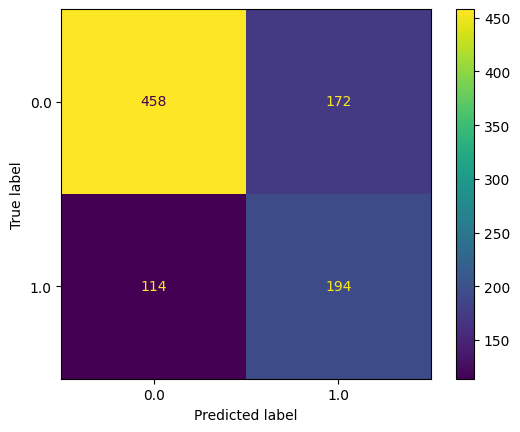

In [22]:


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

dataset_metrics = profile_json["dataset_metrics"]
cm_metric_result = dataset_metrics["ConfusionMatrix"]["metric_data"]
matrix = cm_metric_result[0]
labels = cm_metric_result[1]

numpyArrayMatrix = np.array(matrix)
numpyArrayLabel = np.array(labels)


disp = ConfusionMatrixDisplay(confusion_matrix=numpyArrayMatrix,
                              display_labels=numpyArrayLabel)

disp.plot()

plt.show()